In [343]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import os
from mlxtend.frequent_patterns import apriori, association_rules

class Generate_Associations():
    """
    Generate associations at the order or customer level and return PDF plot of associations
    Input required index and columns for crosstabulation of one-hot matrix vectorization
    E.g., index = Customer_No and columns = Prodh3 looks at customer associations at the H3 level
    """
    def __init__(self, data, index, columns):
        self.data = data #input cleaned data
        self.index = index 
        self.columns = columns

    def freq_itemset_generation(self, min_support=0.01):
        """
        Minimum support is default set to 1%
        """
        # get all the things
        data = self.data
        index = self.index
        columns = self.columns
        
        #generate frequent itemsets
        freq_items = apriori(
            pd.crosstab(index=data[index], columns=data[columns]) > 1, # one-hot vectorization
            min_support = min_support, 
            use_colnames=True
        )
        print('Total Itemsets:', len(freq_items))
        return freq_items

    def rules_generation(self, min_support=0.01):
        # generate frequent itemsets
        freq_items = self.freq_itemset_generation(min_support=min_support)
        
        #generate association rules
        rules = association_rules(freq_items, metric="confidence", min_threshold=0.1)

        # get total number of orders
        rules['orders'] = (rules['support']*df['SalesOrder'].nunique()).astype(int)

        # order by confidence and reset index
        rules = rules.sort_values(['leverage'], ascending=False).reset_index(drop=True)

        # change frozensets to lists
        rules['antecedents'] = rules['antecedents'].apply(lambda y: [x for x in y])
        rules['consequents'] = rules['consequents'].apply(lambda y: [x for x in y])

        # return rules
        print("Count of Rules:", len(rules))
        return rules
    
    def create_graph(self, rules_to_show, min_support=0.01, file_name=None):
        """
        Construct directed network graph of rules. Nodes identify rules, e.g, R0, R1, etc.
        """
        rules = self.rules_generation(min_support=min_support)
        
        import networkx as nx  
        G1 = nx.DiGraph()

        color_map=[]
        N = 50
        #colors = np.random.rand(N) 
        colors = rules['conviction']
        strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   

        for i in range (rules_to_show):      
            G1.add_nodes_from(["R"+str(i)])

            for a in rules.iloc[i]['antecedents']:
                G1.add_nodes_from([a])
                G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)

            for c in rules.iloc[i]['consequents']:
                G1.add_nodes_from([c])
                G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)

        for node in G1:
            found_a_string = False

            for item in strs: 
                if node==item:
                    found_a_string = True
            if found_a_string:
                color_map.append('yellow')
            else:
                color_map.append('orange')       

        edges = G1.edges()
        colors = [G1[u][v]['color'] for u,v in edges]
        weights = [G1[u][v]['weight'] for u,v in edges]

        pos = nx.spring_layout(G1, k=16, scale=1)
        plt.figure(1,figsize=(10,8)) 
        
        # draw graph
        d = dict(G1.degree)
        cmap = plt.cm.Spectral_r
        nx.draw(G1, pos, 
                node_color=color_map, 
                node_size=[v * 100 for v in d.values()], 
                edge_color=colors, 
                width=weights, 
                font_size=16, 
                with_labels=False,
                edge_cmap = cmap)  
        
        # add color bar
        vmin = 0
        vmax = rules['conviction'].max()
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
        sm._A = []
        plt.colorbar(sm, shrink=0.7)#, pad=0.04)

        for p in pos:  # raise text positions
               pos[p][1] += 0.07
        nx.draw_networkx_labels(G1, pos)
        
        if file_name:
            plt.savefig(file_name)
            
        plt.show()

    def get_website_image(file_name='1956.jpg'):
        """
        Return save website image from folder if it exists or download and save requested website image
        Only works for associations which have website images, e.g., SKUs or PIDs
        """
        # base path
        path = 'https://productimages.edmundoptics.com'

        # image exists
        if os.path.isfile('website_images/' + file_name) == False:
            url = path + '/' + file_name
            image = io.imread(url)
            io.imsave('website_images/{}'.format(file_name), image) # save image

        else:
            with open('website_images/{}'.format(file_name)) as file:
                image = file

        return image     

    def rules_pdf_plot(rules, fig_title, n_rows=100):
        # number of rows to output
        n_rows = n_rows

        # number of ants vs  number of rows
        subplot_map = pd.concat(
            [
                rules['antecedents'].apply(lambda x: len([y for y in x])).head(n_rows),
                rules['consequents'].apply(lambda x: len([y for y in x])).head(n_rows)
            ],
            axis=1
        )

        fig, ax = plt.subplots(n_rows, subplot_map.sum(axis=1).max()+1, figsize=(10,n_rows*1.8))

        ax = ax.ravel()
        i=0

        for k in np.arange(n_rows):
            ants = [x for x in rules.iloc[k]['antecedents']] 
            cons = [x for x in rules.iloc[k]['consequents']]

            ax[i].set_ylabel('orders:' + ' ' + str(rules.loc[k,'orders']))
            ################ plot ants ################
            file_names = pd.read_csv('matnr_file_names.csv')
            for part in ants:    

                file_name = file_names[file_names['MaterialNumber'] == part]['FileName'].iloc[0]
                image = get_website_image(file_name=file_name)
                ax[i].imshow(io.imread('website_images/{}'.format(file_name)))

                ax[i].set_title(str(part))

                # get rid of ticks
                ax[i].tick_params(
                    axis='both',         
                    which='both',      
                    bottom=False,     
                    top=False,     
                    left=False,
                    labelbottom=False,
                    labelleft=False
                )

                i+=1

            ################# plot arrow ################
            bbox_props = dict(boxstyle="rarrow,pad=0.5", fc="red", ec="b", lw=0.001)
            t = ax[i].text(0.5, 0.5, '{}'.format(str(round(100*rules.loc[k,'confidence'],1)) + '%'), ha="center", va="center", rotation=0,
                size=15,
                bbox=bbox_props)
            ax[i].axis('off')

            i += 1
            ################# plot cons ################
            for part in cons:    

                file_name = file_names[file_names['MaterialNumber'] == part]['FileName'].iloc[0]
                image = get_website_image(file_name=file_name)
                ax[i].imshow(io.imread('website_images/{}'.format(file_name)))

                ax[i].set_title(str(part))

                # get rid of ticks
                ax[i].tick_params(
                    axis='both',         
                    which='both',      
                    bottom=False,     
                    top=False,     
                    left=False,
                    labelbottom=False,
                    labelleft=False
                )

                i+=1

            ################# plot missing ################
            for j in np.arange(subplot_map.sum(axis=1).max()+1)[len(ants+cons)+1:]:    

                # make blank plot
                ax[k*(subplot_map.sum(axis=1).max()+1)+ j].axis('off')
                i+=1

        # remove spines
        for j in np.arange(i):
                ax[j].spines['top'].set_visible(False)
                ax[j].spines['right'].set_visible(False)
                ax[j].spines['bottom'].set_visible(False)
                ax[j].spines['left'].set_visible(False)
                ax[j].grid(False)


        plt.tight_layout()
        plt.savefig(fig_title)

In [2]:
######################### Test #########################
# import queried data
df = pd.read_csv('h3_association_data.csv', low_memory=False)

# look at only dat from 2019 to date
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,Customer_No,Customer,SalesOrder,Prodh3,ProductHierarchy,Matnr,Qty
0,2021-12-20,1105388,santec株式会社,2086095,OPM,SO OPM OTU,43327000,1
1,2021-12-20,1106709,株式会社ﾓﾘﾀ製作所,2079620,OPW,SO OPW QUT,36991,1
2,2021-12-20,1105811,遠藤科学株式会社,2086060,OPL,SO OPL LMV,38764,1
3,2021-12-20,1105811,遠藤科学株式会社,2086060,OPL,SO OPL LMV,38764,1
4,2021-12-20,1106709,株式会社ﾓﾘﾀ製作所,2079620,OPO,SO OPO FHT,19018,1


In [344]:
# initialize class
ga = Generate_Associations(df, index='SalesOrder', columns='Prodh3')

In [314]:
# test frequent itemset generation with a priori alogorithm
min_support = 0.0005
ga.freq_itemset_generation(min_support=min_support).head()

Total Itemsets: 23


,support,itemsets
0,0.001748,(LAA)
1,0.001049,(MIC)
2,0.004755,(OPB)
3,0.068811,(OPF)
4,0.204126,(OPL)


Total Itemsets: 23
Count of Rules: 7


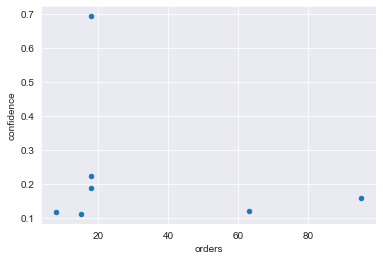

In [315]:
# test rules generation
import seaborn as sns
sns.set_style('darkgrid')

rules = ga.rules_generation(min_support=min_support)
rules.plot(x='orders', y='confidence', kind='scatter')
plt.show()

Total Itemsets: 23
Count of Rules: 7


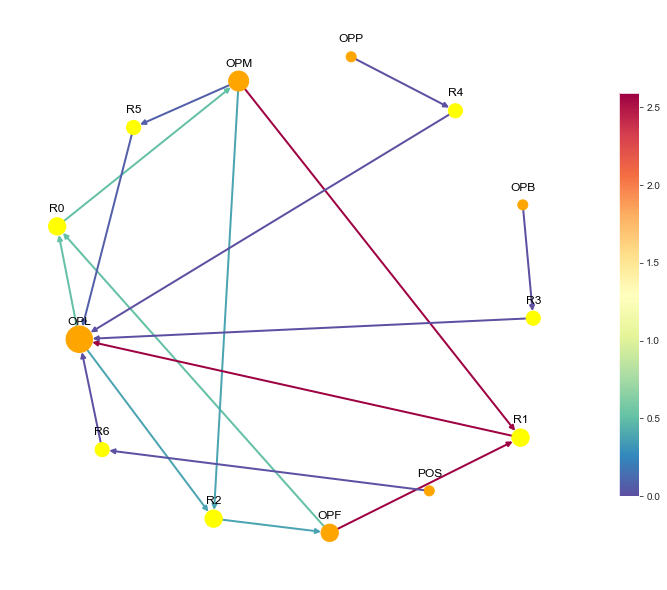

In [345]:
ga.create_graph(rules_to_show=7, min_support=min_support, file_name='h3_orders_graph.png')

In [121]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,orders
0,"[OPF, OPL]",[OPM],0.005664,0.041678,0.001259,0.222222,5.331842,0.001023,1.232128,18
1,"[OPF, OPM]",[OPL],0.001818,0.204126,0.001259,0.692308,3.391572,0.000888,2.586591,18
2,"[OPL, OPM]",[OPF],0.006643,0.068811,0.001259,0.189474,2.753530,0.000802,1.148869,18
3,[OPB],[OPL],0.004755,0.204126,0.000559,0.117647,0.576346,-0.000411,0.901991,8
4,[OPP],[OPL],0.009371,0.204126,0.001049,0.111940,0.548389,-0.000864,0.896194,15
5,[OPM],[OPL],0.041678,0.204126,0.006643,0.159396,0.780871,-0.001864,0.946788,95
6,[POS],[OPL],0.036364,0.204126,0.004406,0.121154,0.593525,-0.003017,0.905590,63


In [264]:
G1.degree
[x for x in G1.nodes]

['R0',
 'OPF',
 'OPL',
 'OPM',
 'R1',
 'R2',
 'R3',
 'OPB',
 'R4',
 'OPP',
 'R5',
 'R6',
 'POS']

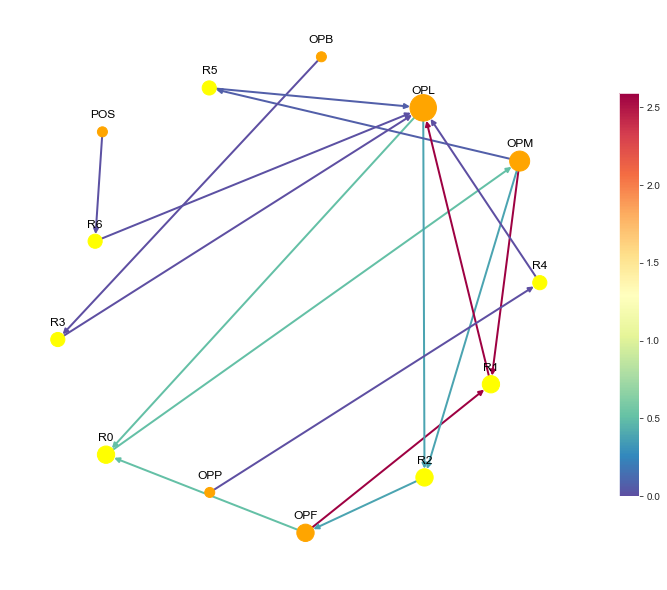

In [342]:
import networkx as nx  
G1 = nx.DiGraph()

rules_to_show = 7

color_map=[]
node_sizes = []
N = 50
colors = np.random.rand(N)
colors = rules['conviction']
strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   

s = 10
for i in range (rules_to_show):
    node_sizes.append(rules.iloc[i]['orders'])
    G1.add_nodes_from(["R"+str(i)])
    
    for a in rules.iloc[i]['antecedents']:
        #node_sizes.append(s)
        G1.add_nodes_from([a])
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)

    for c in rules.iloc[i]['consequents']:
        #node_sizes.append(s)
        G1.add_nodes_from([c])
        G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
    
for node in G1:
    found_a_string = False
    for item in strs: 
        if node==item:
            found_a_string = True
    if found_a_string:
        color_map.append('yellow')
    else:
        color_map.append('orange')       

edges = G1.edges()
colors = [G1[u][v]['color'] for u,v in edges]
weights = [G1[u][v]['weight'] for u,v in edges]
node_size = [(x, x) for x in rules['orders']][:rules_to_show]

pos = nx.spring_layout(G1, k=16, scale=1)
plt.figure(1,figsize=(10,8)) 

d = dict(G1.degree)
cmap = plt.cm.Spectral_r
nx.draw(G1, pos, 
        node_color=color_map, 
        node_size=[v * 100 for v in d.values()], 
        edge_color=colors, 
        width=weights, 
        font_size=16, 
        with_labels=False,
        edge_cmap = cmap)      

vmin = 0
vmax = rules['conviction'].max()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, shrink=0.7, pad=0.04)

for p in pos:  # raise text positions
       pos[p][1] += 0.07
nx.draw_networkx_labels(G1, pos)
plt.show()

In [247]:
[v * 100 for v in d.values()]

[300, 300, 700, 400, 300, 300, 200, 100, 200, 100, 200, 200, 100]

In [280]:
colors

[0.47635204616137755,
 0.47635204616137755,
 1.0,
 0.47635204616137755,
 0.4441635159498265,
 1.0,
 0.4441635159498265,
 0.3660371564563181,
 1.0,
 0.4441635159498265,
 0.34871794871794876,
 0.34871794871794876,
 0.3464770523594053,
 0.3464770523594053,
 0.3660371564563181,
 0.35010940919037203,
 0.35010940919037203]

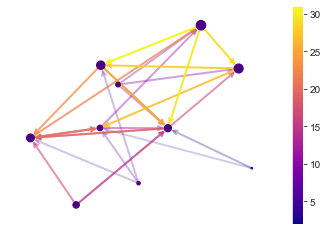

In [190]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

seed = 13648  # Seed random number generators for reproducibility
G = nx.random_k_out_graph(10, 3, 0.5, seed=seed)
pos = nx.spring_layout(G, seed=seed)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [194]:
[G1[u] for u in G1.nodes()]

[AtlasView({'OPM': {'color': 0.06231860994117144, 'weight': 2}}),
 AtlasView({'R0': {'color': 0.06231860994117144, 'weight': 2}, 'R1': {'color': 0.6954482916914473, 'weight': 2}}),
 AtlasView({'R0': {'color': 0.06231860994117144, 'weight': 2}}),
 AtlasView({'R1': {'color': 0.6954482916914473, 'weight': 2}}),
 AtlasView({'OPL': {'color': 0.6954482916914473, 'weight': 2}})]

In [191]:
node_sizes

[3, 13, 23, 33, 43, 53, 63, 73, 83, 93]

In [184]:
G1['R0']

AtlasView({'OPM': {'color': 0.7162776673976561, 'weight': 2}})